# Ballistics

In [89]:
import json
import os
from math import pi

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import fsolve

# Load the autoreload extension
%load_ext autoreload

# Set autoreload mode
%autoreload 2
#%reload_ext autoreload
import ballistics as b


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
# Constants
temp = 20.0 # degrees Celsius
pressure = 1020 * 100# Pa
humidity = 0.778 # 70% humidity

air_density = b.calculate_air_density(temp, pressure, humidity)
os.environ['AIR_DENSITY'] = str(air_density) # kg/m3 needed in ballistics.py

mrad_per_click = 0.10
h = 70 / 1000 # m
d_zero = 100 # m

v0 = 950 # m/s
bc = 0.275
bullet_weight = 55 * 0.00006479891  # kg
bullet_diameter = 0.224 * 0.0254   # m
bullet_area = pi * (bullet_diameter / 2) ** 2  # m2
d_min = 0 # m
d_max = 325 # m


In [91]:
# Base calculations
bc_metric = b.convert_bc_to_metric(bc)
drag_coefficient_g1 = b.calculate_drag_coefficient(bc_metric, bullet_weight, bullet_area)

# Target distance
d_target = d_zero  # Target distance in meters

# Initial guess for the angle
angle_guess = 0
# Function to find the angle that makes y(d_target) = 0 (hit the target at height zero)
def find_angle(a):
    # a is passed as an array, so we extract the scalar value using a[0]
    a = a[0]
    return b.calculate_poi_with_integration(d_zero, drag_coefficient_g1, bullet_weight, bullet_area, h, v0, a)

# Use fsolve to find the correct angle
result = fsolve(find_angle, angle_guess)

optimal_angle = result[0]


In [92]:
step = 25 # m
distances = np.arange(d_min, d_max + step, step) 
velocities = b.calculate_velocities(v0, drag_coefficient_g1, bullet_weight, bullet_area, distances)
pois = b.calculate_pois_with_integration(d_min, d_max, step, drag_coefficient_g1, bullet_weight, bullet_area, h, v0, optimal_angle)
pois_mrad = b.calculate_mrads(distances, pois)
time_to_distances = b.calculate_time_of_flights(v0, drag_coefficient_g1, bullet_weight, bullet_area, distances, optimal_angle)

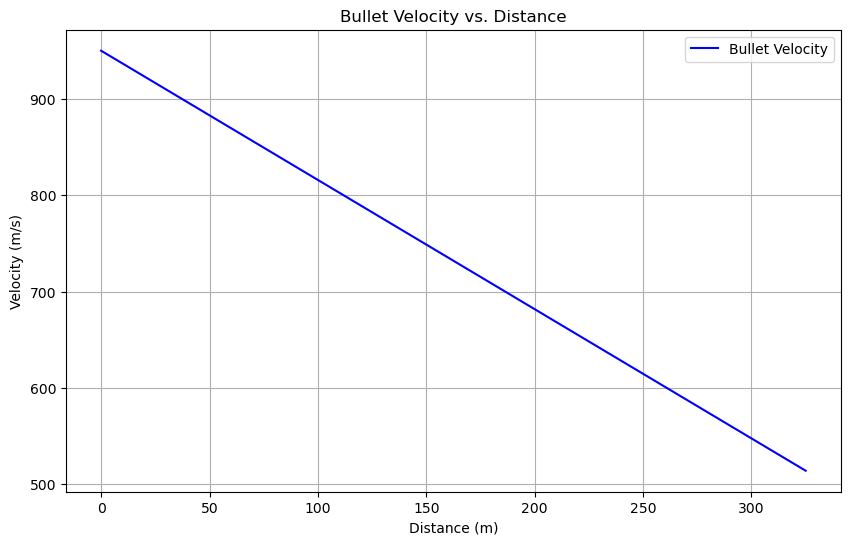

In [93]:
# Plotting the bullet velocity over distance
plt.figure(figsize=(10, 6))
plt.plot(distances, velocities, label='Bullet Velocity', color='blue')
plt.title("Bullet Velocity vs. Distance")
plt.xlabel("Distance (m)")
plt.ylabel("Velocity (m/s)")
plt.grid(True)
plt.legend()
plt.show()

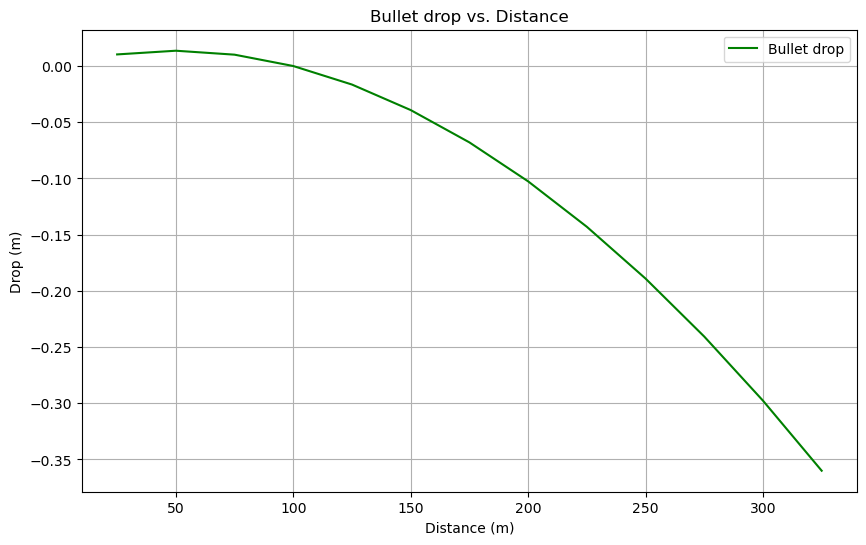

In [94]:
# Plotting the bullet drop over distance
plt.figure(figsize=(10, 6))
plt.plot(distances, pois, label='Bullet drop', color='green')
plt.title("Bullet drop vs. Distance")
plt.xlabel("Distance (m)")
plt.ylabel("Drop (m)")
plt.grid(True)
plt.legend()
plt.show()

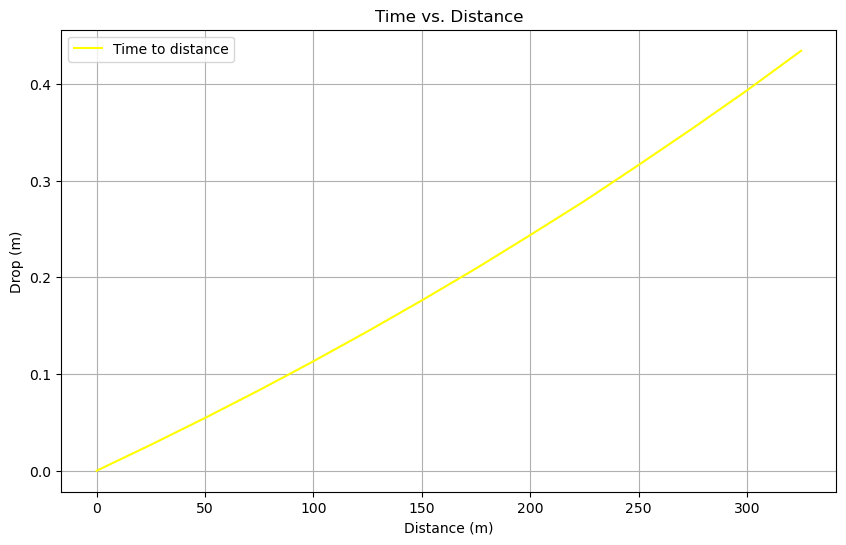

In [95]:
# Plotting the time to distance
plt.figure(figsize=(10, 6))
plt.plot(distances, time_to_distances, label='Time to distance', color='yellow')
plt.title("Time vs. Distance")
plt.xlabel("Distance (m)")
plt.ylabel("Drop (m)")
plt.grid(True)
plt.legend()
plt.show()

In [96]:
# Ballistic tables
velocities = np.round(velocities, 0).astype(int)
times = np.round(time_to_distances, 2)
pois = np.round(pois, 2)
pois_mrad = np.round(pois_mrad, 2)
clicks = np.round(np.array(list(map(lambda x: x/mrad_per_click, pois_mrad)))).astype(int)
d = {'v (m/s)': velocities, 'time (s)': times, 'drop (m)': pois, 'mrads': pois_mrad, 'clicks': clicks}
df = pd.DataFrame(data=d, index=distances)
display(df)


,v (m/s),time (s),drop (m),mrads,clicks
0,950,0.00,NaN,0.00,0
25,916,0.03,0.01,-0.41,-4
50,883,0.05,0.01,-0.27,-3
75,849,0.08,0.01,-0.13,-1
100,816,0.11,0.00,-0.00,0
125,782,0.14,-0.02,0.13,1
150,749,0.18,-0.04,0.26,3
175,715,0.21,-0.07,0.39,4
200,682,0.24,-0.10,0.51,5
225,648,0.28,-0.14,0.64,6
